### Importing required libraries

In [2]:
import cv2
import svm
import numpy as np
import math as m
import sys
import svm
from scipy.special import gamma as tgamma
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import pandas as pd    

def AGGDfit(structdis):
    # variables to count positive pixels / negative pixels and their squared sum
    poscount = 0
    negcount = 0
    possqsum = 0
    negsqsum = 0
    abssum   = 0

    poscount = len(structdis[structdis > 0]) # number of positive pixels
    negcount = len(structdis[structdis < 0]) # number of negative pixels
    
    # calculate squared sum of positive pixels and negative pixels
    possqsum = np.sum(np.power(structdis[structdis > 0], 2))
    negsqsum = np.sum(np.power(structdis[structdis < 0], 2))
    
    # absolute squared sum
    abssum = np.sum(structdis[structdis > 0]) + np.sum(-1 * structdis[structdis < 0])

    # calculate left sigma variance and right sigma variance
    lsigma_best = np.sqrt((negsqsum/negcount))
    rsigma_best = np.sqrt((possqsum/poscount))

    gammahat = lsigma_best/rsigma_best
    
    # total number of pixels - totalcount
    totalcount = structdis.shape[1] * structdis.shape[0]

    rhat = m.pow(abssum/totalcount, 2)/((negsqsum + possqsum)/totalcount)
    rhatnorm = rhat * (m.pow(gammahat, 3) + 1) * (gammahat + 1)/(m.pow(m.pow(gammahat, 2) + 1, 2))
    
    prevgamma = 0
    prevdiff  = 1e10
    sampling  = 0.001
    gam = 0.2

    # vectorized function call for best fitting parameters
    vectfunc = np.vectorize(func, otypes = [np.float], cache = False)
    
    # calculate best fit params
    gamma_best = vectfunc(gam, prevgamma, prevdiff, sampling, rhatnorm)

    return [lsigma_best, rsigma_best, gamma_best] 

def func(gam, prevgamma, prevdiff, sampling, rhatnorm):
    while(gam < 10):
        r_gam = tgamma(2/gam) * tgamma(2/gam) / (tgamma(1/gam) * tgamma(3/gam))
        diff = abs(r_gam - rhatnorm)
        if(diff > prevdiff): break
        prevdiff = diff
        prevgamma = gam
        gam += sampling
    gamma_best = prevgamma
    return gamma_best

#function to create features
def compute_features(img):
    scalenum = 2
    feat = []
    # make a copy of the image 
    im_original = img.copy()

    # scale the images twice 
    for itr_scale in range(scalenum):
        im = im_original.copy()
        # normalize the image
        im = im / 255.0

        # calculating MSCN coefficients
        mu = cv2.GaussianBlur(im, (7, 7), 1.166)
        mu_sq = mu * mu
        sigma = cv2.GaussianBlur(im*im, (7, 7), 1.166)
        sigma = (sigma - mu_sq)**0.5
        
        # structdis is the MSCN image
        structdis = im - mu
        structdis /= (sigma + 1.0/255)
        
        # calculate best fitted parameters from MSCN image
        best_fit_params = AGGDfit(structdis)
        # unwrap the best fit parameters 
        lsigma_best = best_fit_params[0]
        rsigma_best = best_fit_params[1]
        gamma_best  = best_fit_params[2]
        
        # append the best fit parameters for MSCN image
        feat.append(gamma_best)
        feat.append((lsigma_best*lsigma_best + rsigma_best*rsigma_best)/2)

        # shifting indices for creating pair-wise products
        shifts = [[0,1], [1,0], [1,1], [-1,1]] # H V D1 D2

        for itr_shift in range(1, len(shifts) + 1):
            OrigArr = structdis
            reqshift = shifts[itr_shift-1] # shifting index

            # create transformation matrix for warpAffine function
            M = np.float32([[1, 0, reqshift[1]], [0, 1, reqshift[0]]])
            ShiftArr = cv2.warpAffine(OrigArr, M, (structdis.shape[1], structdis.shape[0]))
            
            Shifted_new_structdis = ShiftArr
            Shifted_new_structdis = Shifted_new_structdis * structdis
            # shifted_new_structdis is the pairwise product 
            # best fit the pairwise product 
            best_fit_params = AGGDfit(Shifted_new_structdis)
            lsigma_best = best_fit_params[0]
            rsigma_best = best_fit_params[1]
            gamma_best  = best_fit_params[2]

            constant = m.pow(tgamma(1/gamma_best), 0.5)/m.pow(tgamma(3/gamma_best), 0.5)
            meanparam = (rsigma_best - lsigma_best) * (tgamma(2/gamma_best)/tgamma(1/gamma_best)) * constant

            # append the best fit calculated parameters            
            feat.append(gamma_best) # gamma best
            feat.append(meanparam) # mean shape
            feat.append(m.pow(lsigma_best, 2)) # left variance square
            feat.append(m.pow(rsigma_best, 2)) # right variance square
        
        # resize the image on next iteration
        im_original = cv2.resize(im_original, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    return feat

In [3]:
# function to create features and scale them
# takes input of the image path
def test_measure_BRISQUE(imgPath):
    # read image from given path
    dis = cv2.imread(imgPath, 1)
    if(dis is None):
        print("Wrong image path given")
        print("Exiting...")
        sys.exit(0)
    # convert to gray scale
    dis = cv2.cvtColor(dis, cv2.COLOR_BGR2GRAY)

    # compute feature vectors of the image
    features = compute_features(dis)

    # rescale the brisqueFeatures vector from -1 to 1
    x = [0]
    
    # pre loaded lists from Module to rescale brisquefeatures vector to [-1, 1]
    min_= [0.336999 ,0.019667 ,0.230000 ,-0.125959 ,0.000167 ,0.000616 ,0.231000 ,-0.125873 ,0.000165 ,0.000600 ,0.241000 ,-0.128814 ,0.000179 ,0.000386 ,0.243000 ,-0.133080 ,0.000182 ,0.000421 ,0.436998 ,0.016929 ,0.247000 ,-0.200231 ,0.000104 ,0.000834 ,0.257000 ,-0.200017 ,0.000112 ,0.000876 ,0.257000 ,-0.155072 ,0.000112 ,0.000356 ,0.258000 ,-0.154374 ,0.000117 ,0.000351]
    
    max_= [9.999411, 0.807472, 1.644021, 0.202917, 0.712384, 0.468672, 1.644021, 0.169548, 0.713132, 0.467896, 1.553016, 0.101368, 0.687324, 0.533087, 1.554016, 0.101000, 0.689177, 0.533133, 3.639918, 0.800955, 1.096995, 0.175286, 0.755547, 0.399270, 1.095995, 0.155928, 0.751488, 0.402398, 1.041992, 0.093209, 0.623516, 0.532925, 1.042992, 0.093714, 0.621958, 0.534484]

    # append the rescaled vector to x 
    for i in range(0, 36):
        min = min_[i]
        max = max_[i] 
        x.append(-1 + (2.0/(max - min) * (features[i] - min)))
    
    
    return x

In [4]:
# listing names of bad quality & good quality images
bq = os.listdir(r'E:\Downloads\iqa_assignment\bad_quality')
gq = os.listdir(r'E:\Downloads\iqa_assignment\good_quality')

In [6]:
#reading good quality images & creating features for them in a df , df_gq
count=0
df_gq = pd.DataFrame(columns=np.arange(0,37))
for i in gq:
    
    df_gq.loc[count]=test_measure_BRISQUE(r'E:\Downloads\iqa_assignment\good_quality'+"//"+i) 
    count=count+1

C:\Users\Nidhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in sqrt


In [7]:
#reading good quality images & creating features for them in a df , df_bq
df_bq = pd.DataFrame(columns=np.arange(0,37))
for i in bq:
    
    df_bq.loc[count]=test_measure_BRISQUE(r'E:\Downloads\iqa_assignment\bad_quality'+"//"+i) 
    count=count+1

C:\Users\Nidhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
#defining target
df_bq['target']=0
df_gq['target']=1
df = pd.concat([df_bq, df_gq], axis=0)
df.drop(0, axis=1, inplace=True)

In [22]:
#train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, stratify=df['target'], random_state=1)

In [126]:
from sklearn import svm
clf = svm.SVC(C= 1000, gamma= 0.01,class_weight = {0:1, 1:3}, kernel= 'rbf')
# clf=svm.SVC(gamma='scale')
clf.fit(x_train, y_train)

SVC(C=1000, cache_size=200, class_weight={0: 1, 1: 3}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [127]:
preds=clf.predict(x_test)

In [128]:
from sklearn.metrics import f1_score
f1_score(preds, y_test)

0.6540880503144655

In [129]:
print(classification_report(y_test, preds, target_names = ['Bad Quality','Good quality']))

              precision    recall  f1-score   support

 Bad Quality       0.98      0.97      0.98      2250
Good quality       0.62      0.69      0.65       150

    accuracy                           0.95      2400
   macro avg       0.80      0.83      0.81      2400
weighted avg       0.96      0.95      0.96      2400



In [87]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear'] }
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(x_train, y_train)

C:\Users\Nidhi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.937, total=   0.7s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.937, total=   0.7s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.938, total=   0.5s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.937, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.937, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.938, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.937, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.937, total=   0.4s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.938, total=   0.4s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] .

[CV] ...... C=1000, gamma=1, kernel=linear, score=0.956, total=   7.0s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.957, total=   6.7s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.952, total=   4.7s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] .... C=1000, gamma=0.1, kernel=linear, score=0.956, total=   6.9s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] .... C=1000, gamma=0.1, kernel=linear, score=0.957, total=   6.7s
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] .... C=1000, gamma=0.1, kernel=linear, score=0.952, total=   4.6s
[CV] C=1000, gamma=0.01, kernel=linear ...............................
[CV] ... C=1000, gamma=0.01, kernel=linear, score=0.956, total=   6.9s
[CV] C=1000, gamma=0.01, kernel=linear ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [88]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1000, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Visualization

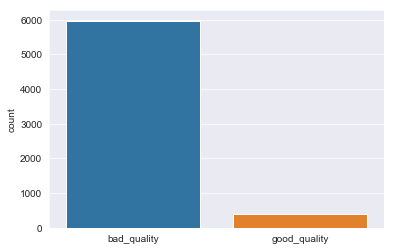

In [4]:
# distribution of bad and good quality images in training data
l = []
for i in train:
    if(i[1] == 0):
        l.append("bad_quality")
    else:
        l.append("good_quality")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'bad_quality')

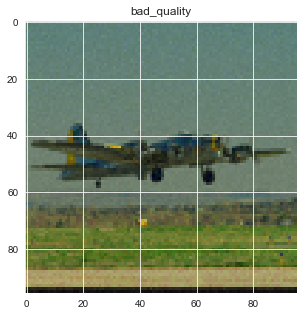

In [5]:
# a bad quality image
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'good_quality')

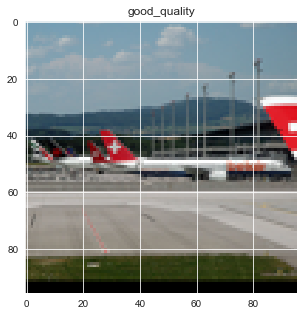

In [6]:
#a good quality image
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])